In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [2]:
# Load preprocessed data
df = pd.read_csv('../Data/preprocessed.csv', index_col=0)
df.time = pd.to_datetime(df.time)
df.head()

,time,use,gen,Dishwasher,Furnace 1,Furnace 2,Home office,Fridge,Wine cellar,Garage door,...,windBearing,precipIntensity,dewPoint,precipProbability,month,day,weekday,weekofyear,hour,minute
0,2016-01-01 05:00:00,0.932833,0.003483,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,0.013083,...,282.0,0.0,24.4,0.0,1,1,0.0,53,5,0
1,2016-01-01 05:01:00,0.934333,0.003467,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,0.013117,...,282.0,0.0,24.4,0.0,1,1,0.0,53,5,1
2,2016-01-01 05:02:00,0.931817,0.003467,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,0.013083,...,282.0,0.0,24.4,0.0,1,1,0.0,53,5,2
3,2016-01-01 05:03:00,1.022050,0.003483,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,0.013000,...,282.0,0.0,24.4,0.0,1,1,0.0,53,5,3
4,2016-01-01 05:04:00,1.139400,0.003467,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,0.012783,...,282.0,0.0,24.4,0.0,1,1,0.0,53,5,4


In [3]:
# Resample data to hourly
resampled_df = df.set_index('time')
resampled_df = resampled_df.resample('H').mean()
resampled_df.shape

(8399, 35)

In [4]:
# Create 80,10,10 train test validation split
target = 'use'

# Split data
train = resampled_df[0:int(len(resampled_df)*0.8)]
valid = resampled_df[int(len(resampled_df)*0.8):int(len(resampled_df)*0.9)]
test = resampled_df[int(len(resampled_df)*0.9):]

# Create X and Y
X_train, Y_train = train.drop([target], axis=1), train[target]
X_valid, Y_valid = valid.drop([target], axis=1), valid[target]
X_test, Y_test = test.drop([target], axis=1), test[target]

In [30]:
# Create an evaulator function
def evaluator(y_pred, y_valid, y_test, pred_frame, plot, save) :
    
    print('MAE:', mean_absolute_error(y_test[:pred_frame], y_pred[:pred_frame]))
    print('MSE:', mean_squared_error(y_test[:pred_frame], y_pred[:pred_frame]))
    
    if plot:
        fig, ax = plt.subplots(figsize=(8, 4)) 
        plt.plot(pd.concat([y_valid[-pred_frame*2:], y_test[0:pred_frame]]).index, pd.concat([y_valid[-pred_frame*2:], y_test[0:pred_frame]]).values, label='Actual Usage')
        plt.plot(y_pred[0:pred_frame].index, y_pred[0:pred_frame].values, label='Forecast Usage')
        y_labels = ax.get_yticks()
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2fkw'))
        ax.legend(['Actual', 'Forecast'])
        plt.xlabel('Date')
        plt.ylabel("Eletrical Usage")
        plt.title(str(round(pred_frame/24)) + "-day forecast energy usage using LightGBM")
        plt.gcf().autofmt_xdate()
        plt.show()
        if save:
            plt.savefig('../Figures/'+str(pred_frame)+'-day.png')
    

In [7]:
# Load training and validation data
lgb_train = lgb.Dataset(X_train, Y_train)
lgb_valid = lgb.Dataset(X_valid, Y_valid)

In [67]:
# Model 1: Gradient Descent LGBM Model
lgbm_gd = lgb.train({
        'task' : 'train',
        'objective' : 'regression',
        'boosting':'gbdt',
        'learning_rate':0.05,
        'metric' : {'mse','mae'},
        'num_leaves':200,
        'seed':42,
    }, 
    train_set = lgb_train,
    num_boost_round = 1000,
    valid_sets = [lgb_train, lgb_valid],
    early_stopping_rounds=10)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7076
[LightGBM] [Info] Number of data points in the train set: 6719, number of used features: 33
[LightGBM] [Info] Start training from score 0.874435
[1]	training's l1: 0.476862	training's l2: 0.688525	valid_1's l1: 0.376385	valid_1's l2: 0.22302
Training until validation scores don't improve for 10 rounds
[2]	training's l1: 0.455911	training's l2: 0.629002	valid_1's l1: 0.366092	valid_1's l2: 0.211203
[3]	training's l1: 0.435787	training's l2: 0.575157	valid_1's l1: 0.359515	valid_1's l2: 0.202156
[4]	training's l1: 0.416688	training's l2: 0.526503	valid_1's l1: 0.354453	valid_1's l2: 0.195982
[5]	training's l1: 0.398827	training's l2: 0.482044	valid_1's l1: 0.347225	valid_1's l2: 0.191347
[6]	training's l1: 0.38196

In [65]:
# Model 2: DART LGBM Model
lgbm_dart = lgb.train(
      params = {
        'task' : 'train',
        'objective' : 'regression',
        'boosting':'dart',
        'learning_rate':0.01,
        'metric' : {'mse','mae'},
        'drop_seed': 42
      },
      train_set = lgb_train,
      num_boost_round = 75,
      valid_sets = [lgb_train, lgb_valid],
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7076
[LightGBM] [Info] Number of data points in the train set: 6719, number of used features: 33
[LightGBM] [Info] Start training from score 0.874435
[1]	training's l1: 0.495116	training's l2: 0.741663	valid_1's l1: 0.387317	valid_1's l2: 0.235339
[2]	training's l1: 0.49134	training's l2: 0.72918	valid_1's l1: 0.384797	valid_1's l2: 0.232621
[3]	training's l1: 0.487625	training's l2: 0.71696	valid_1's l1: 0.382546	valid_1's l2: 0.230011
[4]	training's l1: 0.483937	training's l2: 0.704968	valid_1's l1: 0.380481	valid_1's l2: 0.227539
[5]	training's l1: 0.480307	training's l2: 0.693229	valid_1's l1: 0.378511	valid_1's l2: 0.2252
[6]	training's l1: 0.476704	training's l2: 0.681736	valid_1's l1: 0.376408	valid_1's l2: 0.

In [36]:
def predict(model, x_test) :
    out_df = pd.DataFrame()
    out_df[target] = model.predict(x_test, num_iteration=model.best_iteration)
    out_df.index = x_test.index
    return out_df

In [39]:
# Predict
dart_pred = predict(lgbm_dart, X_test)
gd_pred = predict(lgbm_gd, X_test)
preds = [dart_pred, gd_pred]

MAE: 0.30649681663420913
MSE: 0.14863105353627112


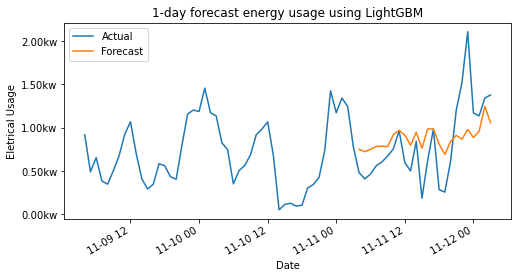

MAE: 0.2746040978773395
MSE: 0.18060002340927786


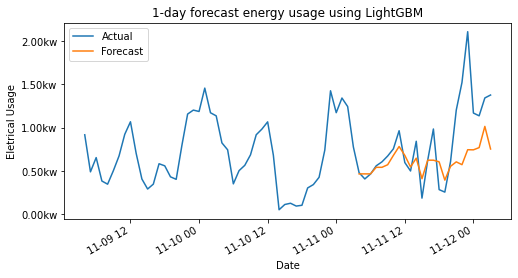

MAE: 0.2800512723837432
MSE: 0.1275893004046256


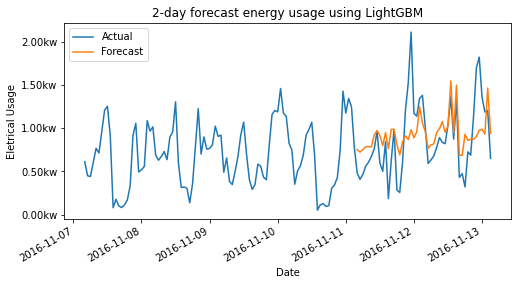

MAE: 0.2639799791985888
MSE: 0.16347831416737843


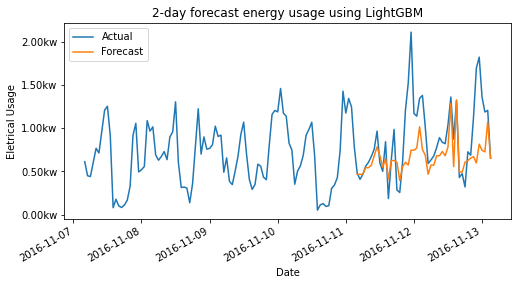

MAE: 0.3134865878608023
MSE: 0.18064073332538783


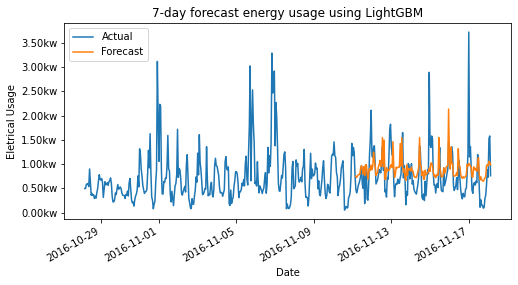

MAE: 0.2487407271473621
MSE: 0.1890654116625342


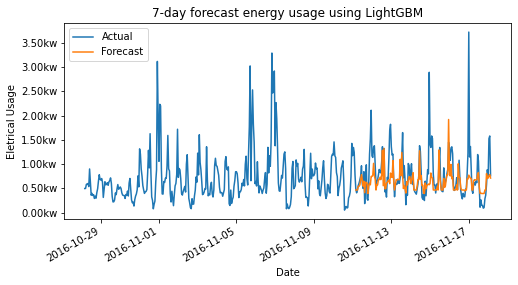

MAE: 0.34941548753585056
MSE: 0.22525349116082416


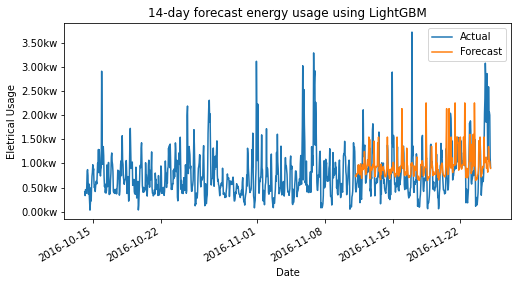

MAE: 0.2996498061195338
MSE: 0.24434787661934704


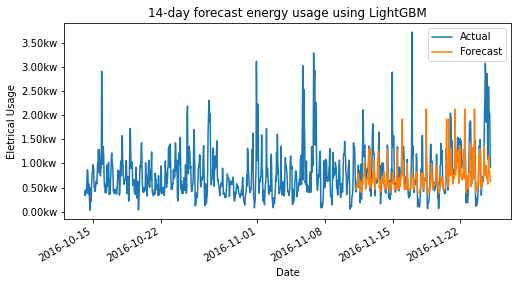

MAE: 0.32501703962251993
MSE: 0.19410311606738676


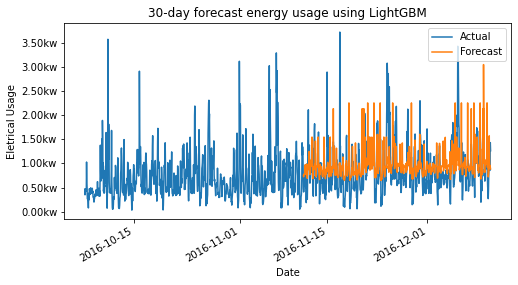

MAE: 0.28379790102446867
MSE: 0.21144498346888085


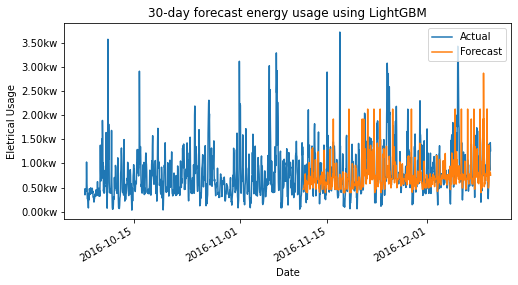

In [38]:
# Plot multi-period forecasts
for period in [24,48,7*24,14*24,30*24] :
    #evaluator(y_pred, y_valid, y_test, pred_frame, plot, save) 
    evaluator(gd_pred['use'], Y_valid, Y_test, period, plot=True, save=False)
    evaluator(dart_pred['use'], Y_valid, Y_test, period, plot=True, save=False)

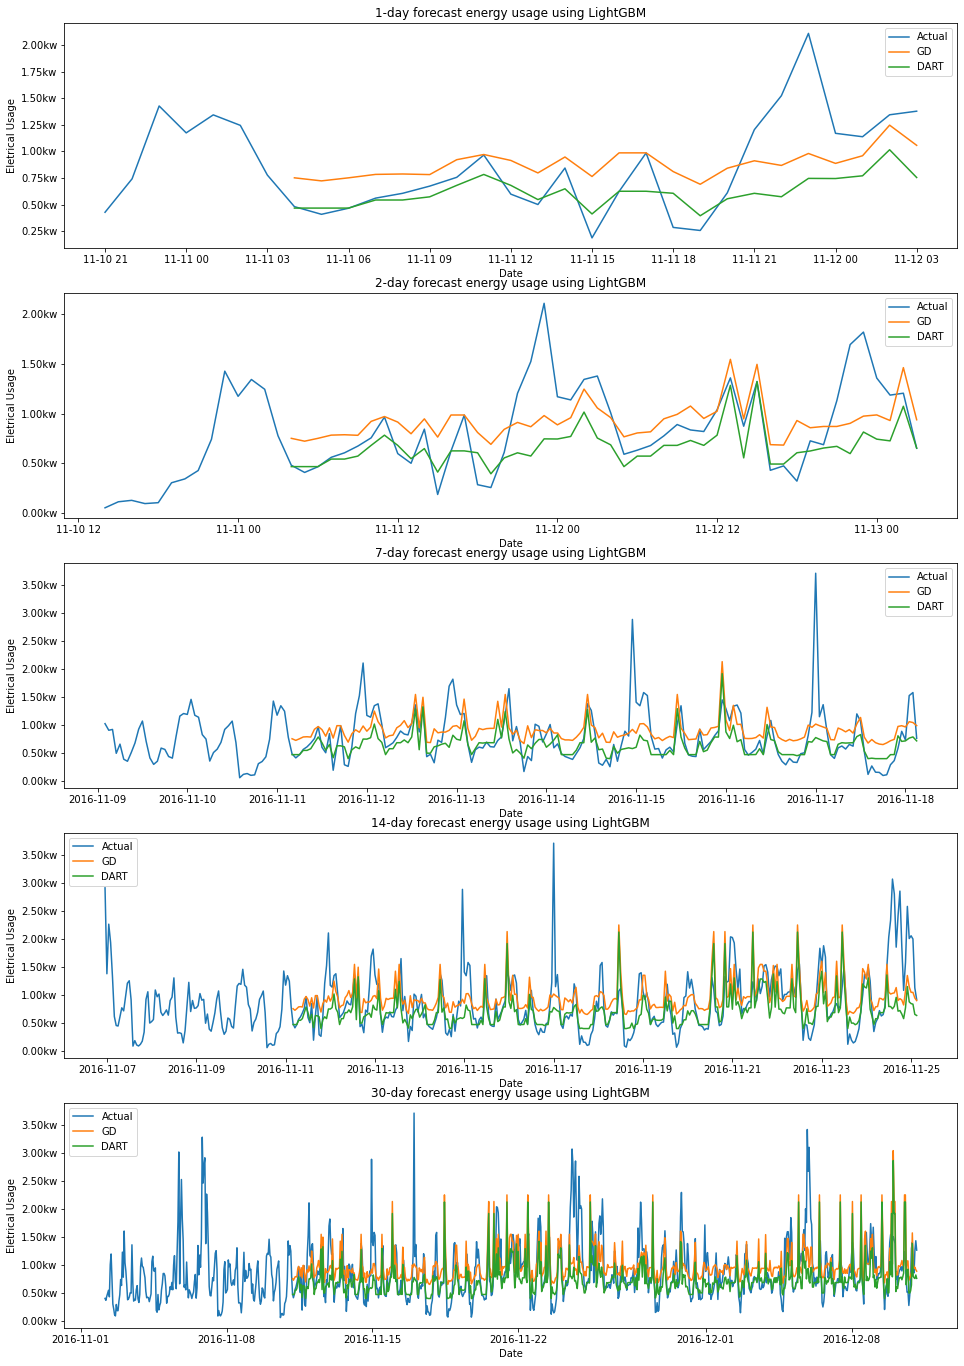

In [61]:
fig,axs = plt.subplots(nrows=5, ncols=1, figsize=(16, 24))
counter = 0
for ax, pred_frame in zip(axs.flat, [24,48,7*24,14*24,30*24]):
    ax.plot(pd.concat([Y_valid[-round(pred_frame*0.3):], Y_test[0:pred_frame]]).index, pd.concat([Y_valid[-round(pred_frame*0.3):], Y_test[0:pred_frame]]).values, label='Actual Usage')
    ax.plot(gd_pred[0:pred_frame].index, gd_pred[0:pred_frame].values, label='GD')
    ax.plot(dart_pred[0:pred_frame].index, dart_pred[0:pred_frame].values, label='DART')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2fkw'))
    ax.legend(['Actual', 'GD','DART'])
    ax.set_xlabel('Date')
    ax.set_ylabel("Eletrical Usage")
    ax.set_title(str(round(pred_frame/24)) + "-day forecast energy usage using LightGBM")
#     ax.gcf().autofmt_xdate()
    counter += 1

plt.savefig('../Figures/forecasts')
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

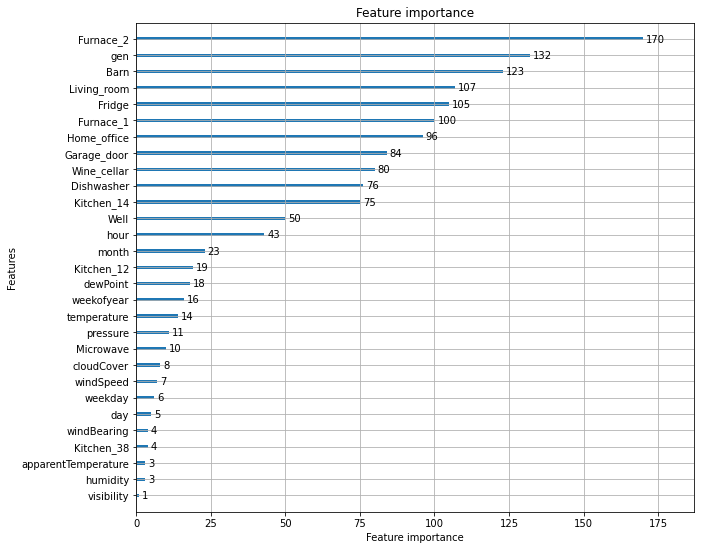

In [57]:
#Feature importances GD
lgb.plot_importance(lgbm_gd, figsize=(10, 9))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

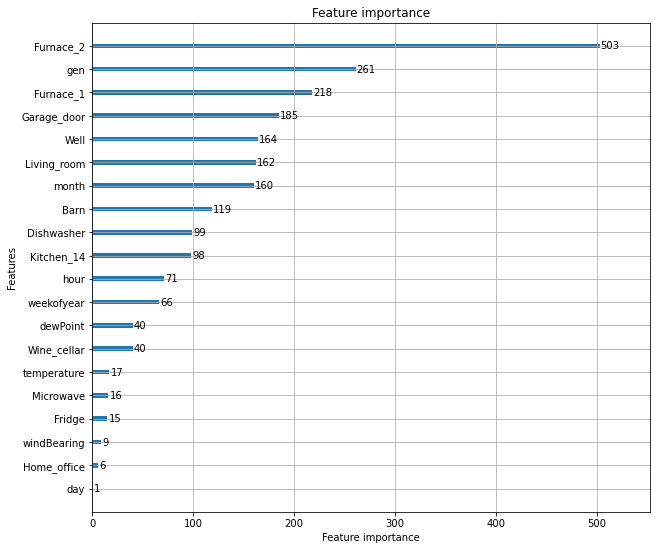

In [58]:
# Cont.
lgb.plot_importance(lgbm_dart, figsize=(10, 9))